## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import math

## Load and transform datasets

In [ ]:
# Change according to your project path
projectPath = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/'

# Mean and std for the normalization of the train-set
mean = [0.4766, 0.4527, 0.3926]
std = [0.2275, 0.2224, 0.2210]

# Mean and std for the normalization of the test- and val-set
meanOriginal = [0.5, 0.5, 0.5]
stdOriginal = [0.5, 0.5, 0.5]

# Transformation for the train-set
# - added random horizontal flip
# - added padding
# - added different normalization parameters
# -> Data Augumentation for a more resilient CNN
transform =  transforms.Compose(
    [transforms.Pad(25, padding_mode='symmetric'),
     transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(),
     transforms.Resize((64,64), antialias=False),
     transforms.Normalize(mean, std)])

# Transformation for the test- and val-set
transformOriginal =  transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64,64), antialias=False),
     transforms.Normalize(meanOriginal, stdOriginal)])


# Batch, to have a certain amount of example pictures
batch_size = 16

# Training-set directory
train_dir = f'{projectPath}train'
# Test-set directory
test_dir = f'{projectPath}test'

# Load training-set
train_set = ImageFolder(train_dir,transform = transform)
train_set_orig = ImageFolder(train_dir,transform = transformOriginal)

# Calculate size of the dataset for the original image data
train_size_orig = int(0.8 * len(train_set_orig))  # 80:20 split (train : val), train later goes up to 90% due to combination
val_size_orig = len(train_set_orig) - train_size_orig

# Split original data into train and val set
train_data_orig, val_data_orig = random_split(train_set_orig,[train_size_orig, val_size_orig], generator=torch.Generator().manual_seed(42))

# Add transformed images to train set
train_data_comb = train_set + train_data_orig

# Load testset
test_set = ImageFolder(test_dir,transform = transformOriginal)

# Create loaders for the train_data_comb and the val_data_orig
trainloader_comb = DataLoader(train_data_comb, batch_size=batch_size, shuffle = True, num_workers = 0)
valloader_orig = DataLoader(val_data_orig, batch_size=batch_size, shuffle = True, num_workers = 0)

## Print random image

In [ ]:
# Get classes (folder names) of the training set
classes = train_set.classes

# Function to show an image out of the training-set
# Print("Follwing classes are there : \n",train_set.classes)
def display_img(img,label):
    print(f"Label : {train_set.classes[label]}")
    img = img / 2 + 0.5 
    img = np.clip(img, 0, 1) # Clip values to the valid range [0, 1]
    plt.imshow(img.permute(1,2,0))

# Display the first image [0] in the dataset
display_img(*val_data_orig[0])    # * to unpack the tuple: (img, label)

## Print first 10 images

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = val_data_orig[i]
    X = X.transpose(0, -1).transpose(0, 1)
    X = np.clip(X, 0, 1)  # Clip values to the valid range [0, 1]
    y = train_set.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y}', fontsize='small')

# CNN Module

In [ ]:
from tqdm import tqdm
import sys
import torch, torch.nn as nn, torch.nn.functional as F

class MyCNNModel(nn.Module):
    def __init__(self, *layers, lr=0.01, classes=None):
        super().__init__() # <- Very important! __init__ from parent class torch.nn 
        self.lr = lr    # learning rate
        self.classes = classes  # classes 
        ## Build model
        self.layers = nn.Sequential(*layers) # Create a sequential model, see below
    
    # Forward pass through the given layers, needed by torch.nn, which is used by train_step
    def forward(self, X):
        return self.layers(X)
    
    # Used after training to predict with the generated model
    def predict(self, X):
        with torch.no_grad():
            y_hat = self(X).argmax(1)
        if self.classes is not None:
            y_hat = [self.classes[i] for i in y_hat]
        return y_hat
    
    # Actual forward pass
    def train_step(self, X, y):
        y_hat = self(X)   # y_hat = prediction, self(X) calls the forward() function above
        # calculates the "cross_entropy"-loss
        return F.cross_entropy(y_hat, y)
        
    def validation_step(self, X, y):
        # temporarily disable gradient, because you don't need it during validation
        with torch.no_grad():
            # calculate the loss, just without the gradient-calculation
            return self.train_step(X, y)
    
    def configure_optimizers(self):
        # self.parameters() = returns an iterator over all the learnable parameters of the model
        # SGD = optimization alg. for nn
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
        
    def fit(self, train_loader, valid_loader, epochs=10):
        # Load Optimizer
        optimizer = self.configure_optimizers()
        
        # Amount of epochs, one epoch is when all batches are fed into the model to train at once
        for epoch in range(epochs):
            print(f'{epoch+1}/{epochs}:')
            # Training
            self.train() # Set model to training model
            # tqm = loading bar, tepoch == array of all batches
            with tqdm(train_loader, unit="batch", desc='Train: ', colour='#1f77b4',\
                      file=sys.stdout, ncols=80) as tepoch:
                # for each batch in tepoch
                for X,y in tepoch:
                    optimizer.zero_grad(set_to_none=True) # Sets all gradients to Zero
                    loss = self.train_step(X, y) # Execute Forward pass
                    loss.backward() # Execute Backwval_dataard pass
                    optimizer.step() # Update weights
                    tepoch.set_postfix(loss=f'{loss.item():1.4f}') # Update progress bar
                    
            # Validation
            self.eval() # Set model to validation mode
            with tqdm(train_loader, unit="batch", desc='Valid: ', colour='#ff7f0e',\
                      file=sys.stdout, ncols=80) as tepoch:
               
                for X,y in tepoch:
                    loss_valid = self.validation_step(X, y) # Execute Forward pass without gradients
                    tepoch.set_postfix(loss=f'{loss_valid.item():1.4f}') # Update progress bar
        return self

## Make .csv with predictions

In [ ]:
import os
import csv

# Class to write the predictions for a given set of images into a .csv
class MakeCSVPredictions:
    def __init__(self, test_set, model, csv_file):
        self.test_set = test_set
        self.model = model
        self.csv_file = csv_file
    
    def writeToCSV(self):
        filenames = []
        for image_path, _ in self.test_set.samples:
            filename = os.path.basename(image_path)
            filenames.append(filename)

        predictions = []
        for i in range(len(self.test_set)): 
            X,y = self.test_set[i]
            y_hat = self.model.predict(X.unsqueeze(0))[0]
            predictions.append(y_hat)


        data = np.column_stack((filenames, predictions))
        with open(self.csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            # Write the data to the CSV file
            writer.writerows(data)

        print("CSV file written successfully.")
        
# Run:
# csv_file = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/prediction.csv'
# MakeCSVPredictions(test_set, model1, csv_file).writeToCSV()AnalyseModel(val_data_orig, model1, train_set.classes).getAccuracy()

## Functions to analyse the model

In [ ]:
# Class to calculate the accuracy of a model by making a prediction for a given set of images
# and comparing the y_hat with the actual y
class AnalyseModel:
    def __init__(self, val_set, model, classes):
        self.val_set = val_set
        self.model = model
        self.classes = classes
    
    def getAccuracy(self):
        predictions = []
        ys = []
        for i in range(len(self.val_set)): 
            X,y = self.val_set[i]
            y_hat = self.model.predict(X.unsqueeze(0))[0]
            y = self.classes[y]
            predictions.append(y_hat)
            ys.append(y)

        count = 0
        for i in range(len(predictions)):
            if predictions[i] == ys[i]:
                count += 1

        accuracy = count / len(predictions)
        
        return accuracy
    
    def getOutput(self):
        f, axarr = plt.subplots(1,10, figsize=(20, 20))
        for i in range(10):
            X,y = self.val_set[i]
            y_hat = self.model.predict(X.unsqueeze(0))[0]
            X = X.transpose(0, -1).transpose(0, 1)
            X = np.clip(X, 0, 1)  # Clip values to the valid range [0, 1]
            y = self.classes[y]
            axarr[i].imshow(X)
            axarr[i].axis('off')
            axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

# Run:
# print(AnalyseModel(val_data_orig, model3, train_set.classes).getAccuracy())
# print(AnalyseModel(val_data_orig, model3, train_set.classes).getOutput())

# Model 3 - ResNet full-preactivation Layer
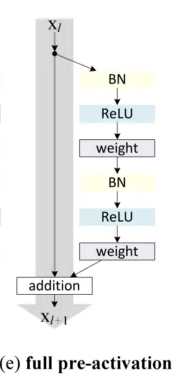

In [ ]:
# Implementation of the full-preactivation ResNet Layer
# Find details on Batch Normalization: https://arxiv.org/abs/1502.03167
class MyResLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, **kwargs):
        super().__init__()
        if in_channels == out_channels:
            self.proj_out = nn.Identity()
        else:
            self.proj_out = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
            
        self.res_block = nn.Sequential(
            nn.BatchNorm2d(in_channels), #BN
            nn.ReLU(), #ReLU
            nn.Conv2d(in_channels, out_channels, kernel, **kwargs), #weight
            nn.BatchNorm2d(out_channels), #BN
            nn.ReLU(), #ReLU
            nn.Conv2d(out_channels, out_channels, kernel, **kwargs), #weight
        )
        
    def forward(self, x):
        x_res = self.res_block(x)
        x = self.proj_out(x)
        return  F.relu(x + x_res) #x + x_res

## Model 3 - CNN

In [ ]:
model3 = MyCNNModel(
    MyResLayer(3, 8, (3,3), padding='same'),
    MyResLayer(8, 8, (3,3), padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
).fit(trainloader_comb, valloader_orig, epochs=10)

## Model 3 - Saving

In [ ]:
torch.save(model3.state_dict(), f'{projectPath}model3.pt')

## Model 3 - Load

In [ ]:
model3 = MyCNNModel(
    MyResLayer(3, 8, (3,3), padding='same'),
    MyResLayer(8, 8, (3,3), padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
)
model3.load_state_dict(torch.load(f'{projectPath}model3.pt'))

## Model 3 - Example Output

In [ ]:
print(AnalyseModel(val_data_orig, model3, train_set.classes).getOutput())

## Model 3 - Accuracy

In [ ]:
print(AnalyseModel(val_data_orig, model3, train_set.classes).getAccuracy())

# Model 4 - Inception Layer Model
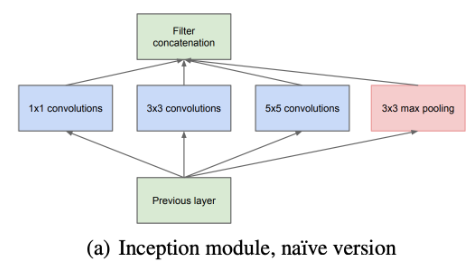

In [ ]:
# Find details on inception: https://arxiv.org/abs/1409.4842one
class MyInceptionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        out_channels = out_channels//4
        self.conv1x = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
        self.conv3x = nn.Conv2d(in_channels, out_channels, (3,3), **kwargs)
        self.conv5x = nn.Conv2d(in_channels, out_channels, (5,5), **kwargs)
        
        self.poolx = nn.Sequential(
            nn.MaxPool2d((3,3), stride=(1,1), padding=1),
            nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
        )
        
    def forward(self, x):
        x_1 = self.conv1x(x)
        x_2 = self.conv3x(x)
        x_3 = self.conv5x(x)
        x_p = self.poolx(x)
        x = torch.cat([x_1, x_2, x_3, x_p], dim=1)
        return F.relu(x)

## Model 4 - CNN

In [ ]:
model4 = MyCNNModel(
    MyInceptionLayer(3, 8, padding='same'),
    MyInceptionLayer(8, 8, padding='same'),
    nn.MaxPool2d(2, 2),
    MyInceptionLayer(8, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
).fit(trainloader_comb, valloader_orig, epochs=10)

## Model 4 - Saving

In [ ]:
torch.save(model4.state_dict(), f'{projectPath}model4.pt')

## Model 4 - Load

In [ ]:
model4 = MyCNNModel(
    MyInceptionLayer(3, 8, padding='same'),
    MyInceptionLayer(8, 8, padding='same'),
    nn.MaxPool2d(2, 2),
    MyInceptionLayer(8, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
)
model4.load_state_dict(torch.load(f'{projectPath}model4.pt'))

## Model 4 - Example Output

In [ ]:
print(AnalyseModel(val_data_orig, model4, train_set.classes).getOutput())

## Model 4 - Accuracy

In [ ]:
print(AnalyseModel(val_data_orig, model4, train_set.classes).getAccuracy())

# Model 5 - Mixing ResNet with Inception CNN

In [ ]:
# Because the Inception-Layer picks up more detail of a given Image, I put it before the downsampling of
# max pooling. After that I used the same ResNet-Layer-structure as before.

model5 = MyCNNModel(
    MyInceptionLayer(3, 8, padding='same'),
    MyInceptionLayer(8, 8, padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
).fit(trainloader_comb, valloader_orig, epochs=10)

## Model 5 - Saving

In [ ]:
torch.save(model5.state_dict(), f'{projectPath}model5.pt')

## Model 5 - Load

In [ ]:
model5 = MyCNNModel(
    MyInceptionLayer(3, 8, padding='same'),
    MyInceptionLayer(8, 8, padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
)
model5.load_state_dict(torch.load(f'{projectPath}model5.pt'))

## Model 5 - Example Output

In [ ]:
print(AnalyseModel(val_data_orig, model5, train_set.classes).getOutput())

## Model 5 - Accuracy

In [ ]:
print(AnalyseModel(val_data_orig, model5, train_set.classes).getAccuracy())

## Model 5 - Write Predictions into .csv

In [ ]:
csv_file = f'{projectPath}prediction.csv'
MakeCSVPredictions(test_set, model5, csv_file).writeToCSV()